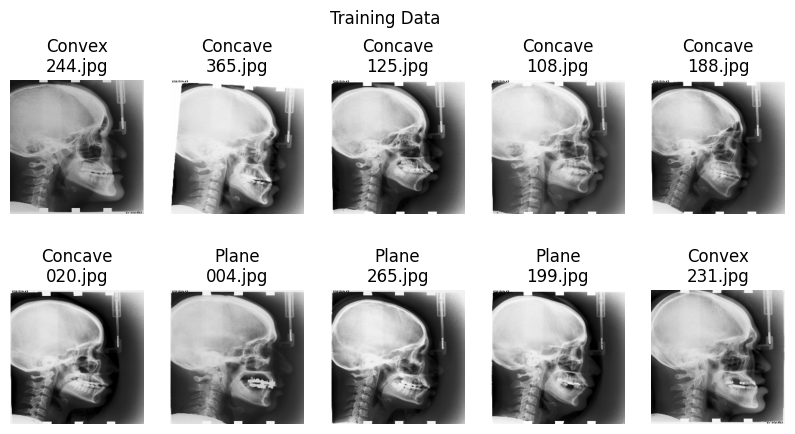

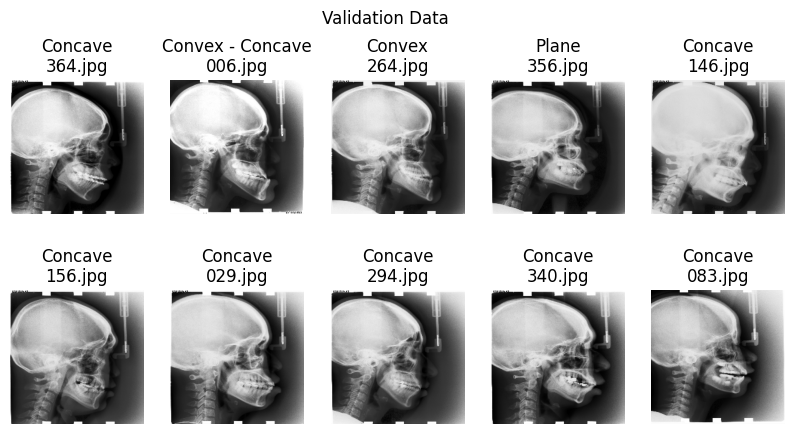

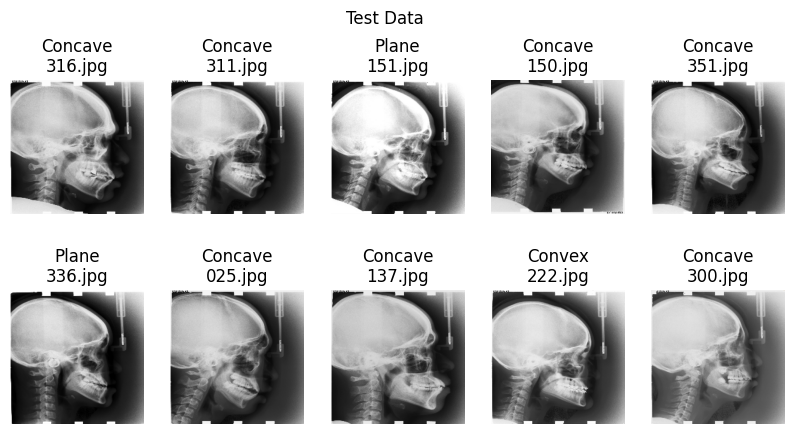

In [4]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, f1_score
import random

# Paths to CSV file and images folder
csv_file = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/Final - Facial Profile Types.csv'
image_folder = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/cepha400'

# Load CSV
df = pd.read_csv(csv_file)

# Remove "Concave - Convex" class
df = df[df['type'] != 'Concave - Convex']

# Function to get zero-padded image filenames
def get_image_path(image_id, folder):
    image_filename = f"{str(image_id).zfill(3)}.jpg"
    return os.path.join(folder, image_filename), image_filename  # Return path and filename

# Prepare dataset: (Image, Tabular Features, Label, Image Name)
combined_data = []
for index, row in df.iterrows():
    image_id = row['data']
    label = row['type']
    upper_lip = row['upper_lip']
    lower_lip = row['lower_lip']

    image_path, image_filename = get_image_path(image_id, image_folder)
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        combined_data.append((img_array, [upper_lip, lower_lip], label, image_filename))
    except FileNotFoundError:
        print(f"Image {image_path} not found.")
        continue
import tensorflow.keras.backend as K



# Convert tabular features to One-Hot Encoding
tabular_features = np.array([sample[1] for sample in combined_data])
encoder = OneHotEncoder(sparse_output=False)
tabular_features_encoded = encoder.fit_transform(tabular_features)

# Encode the labels
labels = [sample[2] for sample in combined_data]
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

# Extract images and image names
images = np.array([sample[0] for sample in combined_data])
image_filenames = np.array([sample[3] for sample in combined_data])

# Create tuples with all mapped features
data_tuples = list(zip(images, tabular_features_encoded, labels_one_hot, image_filenames))

# Split dataset into Train (70%), Validation (15%), Test (15%)
train_data, temp_data = train_test_split(data_tuples, test_size=0.3, stratify=labels_encoded, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[np.argmax(sample[2]) for sample in temp_data], random_state=42)

# Visualization of images and labels after splitting
def visualize_data(data, title):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = random.randint(0, len(data) - 1)
        img, _, label, img_name = data[idx]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{label_encoder.inverse_transform([np.argmax(label)])[0]}\n{img_name}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_data(train_data, "Training Data")
visualize_data(val_data, "Validation Data")
visualize_data(test_data, "Test Data")

# Unpack Train, Validation, Test sets correctly
X_train_img = np.array([sample[0] for sample in train_data])
X_train_tabular = np.array([sample[1] for sample in train_data])
y_train = np.array([sample[2] for sample in train_data])

X_val_img = np.array([sample[0] for sample in val_data])
X_val_tabular = np.array([sample[1] for sample in val_data])
y_val = np.array([sample[2] for sample in val_data])

X_test_img = np.array([sample[0] for sample in test_data])
X_test_tabular = np.array([sample[1] for sample in test_data])
y_test = np.array([sample[2] for sample in test_data])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_images, augmented_tabular, augmented_labels = [], [], []

for i in range(len(X_train_img)):
    img = X_train_img[i].reshape((1,) + X_train_img[i].shape)
    tabular_features = X_train_tabular[i]
    label = y_train[i]

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(5):
        aug_img = next(aug_iter)[0]
        augmented_images.append(aug_img)
        augmented_tabular.append(tabular_features)
        augmented_labels.append(label)

X_train_img = np.vstack([X_train_img, np.array(augmented_images)])
y_train = np.vstack([y_train, np.array(augmented_labels)])
X_train_tabular = np.vstack([X_train_tabular, np.array(augmented_tabular)])





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available:", gpus)
    print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())
else:
    print("No GPU found. Running on CPU.")


GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU: True


Run 2

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization
import tensorflow as tf

# Load EfficientNetB0 as the feature extractor
efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in efficientnetb0.layers:
    layer.trainable = False  # Freeze pre-trained layers

# Image feature extraction
x_img = GlobalAveragePooling2D()(efficientnetb0.output)
x_img = Dense(512, activation='relu')(x_img)
x_img = BatchNormalization()(x_img)
x_img = Dropout(0.5)(x_img)

# Tabular feature extraction
input_tabular = Input(shape=(X_train_tabular.shape[1],), name="tabular_input")
x_tabular = Dense(128, activation='relu')(input_tabular)
x_tabular = BatchNormalization()(x_tabular)
x_tabular = Dropout(0.3)(x_tabular)

# Combine image and tabular features
combined = Concatenate()([x_img, x_tabular])
x = Dense(256, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(y_train.shape[1], activation='softmax')(x)

# Create model
model = Model(inputs=[efficientnetb0.input, input_tabular], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    [X_train_img, X_train_tabular], y_train,
    validation_data=([X_val_img, X_val_tabular], y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 721ms/step - accuracy: 0.4130 - loss: 1.6838 - val_accuracy: 0.9500 - val_loss: 1.1808
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.7565 - loss: 0.6686 - val_accuracy: 0.9500 - val_loss: 1.1210
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8661 - loss: 0.4306 - val_accuracy: 0.9833 - val_loss: 0.8478
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9174 - loss: 0.2519 - val_accuracy: 0.9833 - val_loss: 0.7415
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9572 - loss: 0.1909 - val_accuracy: 0.9833 - val_loss: 0.4795
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9597 - loss: 0.1611 - val_accuracy: 1.0000 - val_loss: 0.3173
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9754 - loss: 0.0988 - val_accuracy: 0.9833 - val_loss: 0.1668
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accu

In [6]:
# Get model predictions
y_pred_probs = model.predict([X_test_img, X_test_tabular])  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step


In [7]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute F1-score (macro & weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")


Classification Report:
                   precision    recall  f1-score   support

         Concave       1.00      1.00      1.00        37
          Convex       1.00      0.91      0.95        11
Convex - Concave       1.00      1.00      1.00         3
           Plane       0.90      1.00      0.95         9

        accuracy                           0.98        60
       macro avg       0.97      0.98      0.97        60
    weighted avg       0.98      0.98      0.98        60

Test Accuracy: 0.9833
Macro F1-score: 0.9749
Weighted F1-score: 0.9834


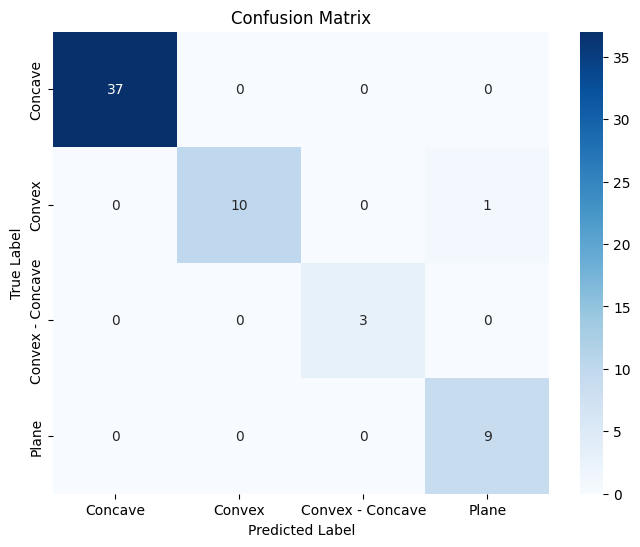

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def compute_gradcam(model, image, tabular_data, layer_name):
    """
    Generate Grad-CAM heatmap for a given image and tabular data.

    Args:
    - model: Trained multimodal model
    - image: Input image (single sample, shape: (224, 224, 3))
    - tabular_data: Corresponding tabular data (single sample, shape: (n_features,))
    - layer_name: Convolutional layer to extract activations

    Returns:
    - Heatmap (overlay on original image)
    """
    # Create a model that maps input image to the activation of the target layer and predictions
    grad_model = tf.keras.models.Model(
        [model.input[0], model.input[1]],  # Image and tabular input
        [model.get_layer(layer_name).output, model.output]
    )

    # Expand dimensions to match batch format
    image_exp = np.expand_dims(image, axis=0)
    tabular_exp = np.expand_dims(tabular_data, axis=0)

    # Get feature map and predictions
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([image_exp, tabular_exp])
        class_idx = np.argmax(predictions)  # Get predicted class index
        loss = predictions[:, class_idx]  # Model's confidence for that class

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute weighted activation map
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = np.dot(conv_outputs, pooled_grads.numpy())

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


In [10]:
def overlay_heatmap(image, heatmap, alpha=0.5):
    """
    Overlay heatmap on original image.

    Args:
    - image: Original image (224, 224, 3)
    - heatmap: Grad-CAM heatmap
    - alpha: Transparency factor

    Returns:
    - Overlayed image
    """
    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Convert to 0-255 scale

    # Apply colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay on image
    overlayed_img = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed_img


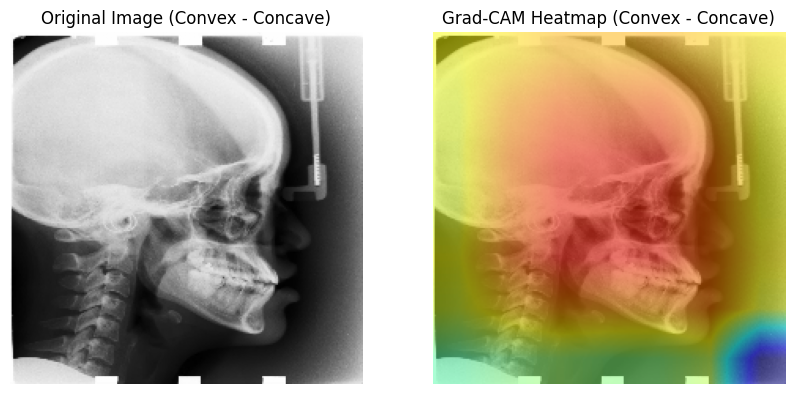

In [16]:
# Select a random test image
idx = np.random.randint(0, len(X_test_img))
sample_image = X_test_img[idx]
sample_tabular = X_test_tabular[idx]
true_label = label_encoder.inverse_transform([np.argmax(y_test[idx])])[0]

# Generate heatmap using last convolutional layer in EfficientNetB0
heatmap = compute_gradcam(model, sample_image, sample_tabular, layer_name="top_conv")

# Overlay heatmap on image
overlayed_image = overlay_heatmap((sample_image * 255).astype(np.uint8), heatmap)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Original Image ({true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title(f"Grad-CAM Heatmap ({true_label})")
plt.axis('off')

plt.show()


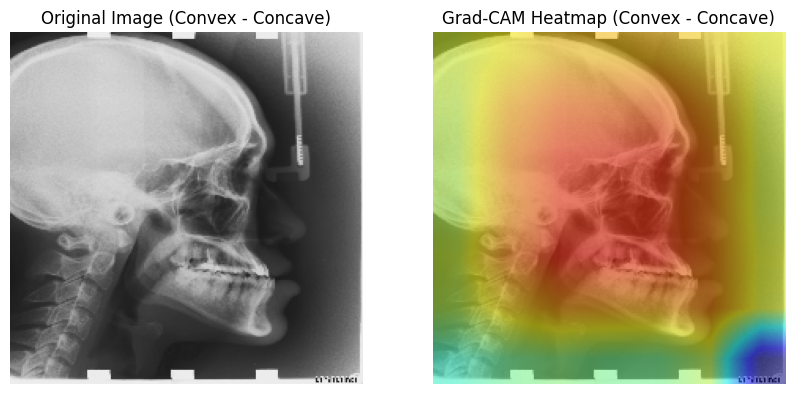

In [26]:
# Select a random test image
idx = np.random.randint(0, len(X_test_img))
sample_image = X_test_img[idx]
sample_tabular = X_test_tabular[idx]
true_label = label_encoder.inverse_transform([np.argmax(y_test[idx])])[0]

# Generate heatmap using last convolutional layer in EfficientNetB0
heatmap = compute_gradcam(model, sample_image, sample_tabular, layer_name="top_conv")

# Overlay heatmap on image
overlayed_image = overlay_heatmap((sample_image * 255).astype(np.uint8), heatmap)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Original Image ({true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title(f"Grad-CAM Heatmap ({true_label})")
plt.axis('off')

plt.show()

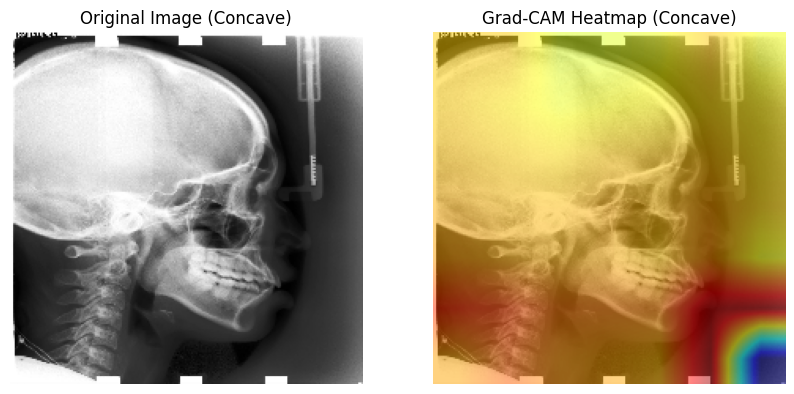

In [38]:
# Select a random test image
idx = np.random.randint(0, len(X_test_img))
sample_image = X_test_img[idx]
sample_tabular = X_test_tabular[idx]
true_label = label_encoder.inverse_transform([np.argmax(y_test[idx])])[0]

# Generate heatmap using last convolutional layer in EfficientNetB0
heatmap = compute_gradcam(model, sample_image, sample_tabular, layer_name="top_conv")

# Overlay heatmap on image
overlayed_image = overlay_heatmap((sample_image * 255).astype(np.uint8), heatmap)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Original Image ({true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title(f"Grad-CAM Heatmap ({true_label})")
plt.axis('off')

plt.show()